In [1]:
!pip install seaborn --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install missingno --quiet
!pip install pywaffle --quiet

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
import time
import math
import os

import missingno as msno
from pywaffle import Waffle

import networkx as nx

Paraméterek és alap beállítások

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['figure.dpi'] = 200 #high resolution

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


In [ ]:
sns.set(
        style="ticks",                 
        rc={"figure.figsize": (6, 9),    
            "figure.facecolor": "#FEFDED",  
            "axes.facecolor": "ivory"})
pd.option_context('mode.use_inf_as_na', True)

A kezdeti gondolatok és kérdések gyűjteménye:
http://simp.ly/p/ZyzbJn

A későbbi adatvizualizációhoz készítek egy template-et

In [13]:
raw_light_palette = [
    (174, 243, 231), 
    (158, 235, 235), 
    (142, 227, 239),
    (99, 170, 191),
    (55, 113, 142),
    (46, 96, 127), 
    (37, 78, 112), 
    (116, 69, 98),
    (195, 60, 84) 
]
light_palette = np.array(raw_light_palette)/255

In [14]:
raw_light_palette_hex = [
    '#AEF3E7',
    '#9EEBEB',
    '#8EE3EF',
    '#63AABF',
    '#37718E',
    '#2E607F',
    '#254E70',
    '#744562',
    '#C33C54'
]

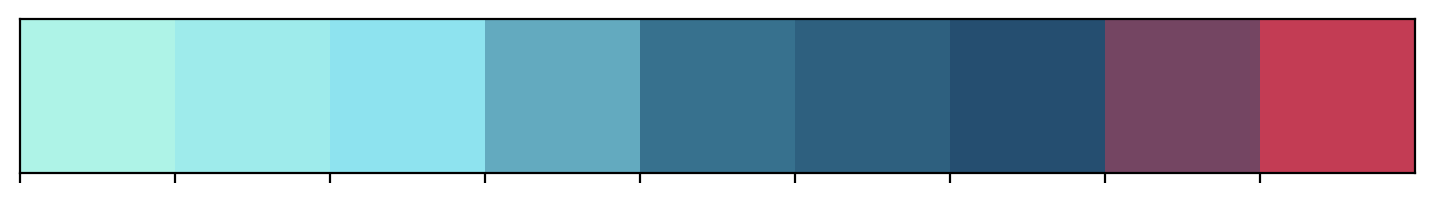

In [15]:
sns.palplot(light_palette)

In [16]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", raw_light_palette_hex)

Függvények

In [91]:
# az outlierek megjenelenítéséhez használt függvény
def num_outliers(df, cols, features_dict):
    plt.figure(figsize=(18, 10))
     
    for i, feature in enumerate(cols, 1):
        plt.subplot(1, 2, i)
        sns.violinplot(y=df[feature], color=light_palette[3])
        sns.stripplot(data = df,          
                          y = feature,
                          color = light_palette[7],
                          linewidth = 2,
                          alpha = 0.1)
        plt.title(features_dict[feature], fontsize=16)
        plt.ylabel(features_dict[feature], fontsize=14)
        plt.xlabel('')  # Removing the x-axis label as it's not needed
     
    plt.tight_layout()
    plt.show();

## 1.0 Adatok betöltése

In [6]:
df = pd.read_csv('./Sources/FileResults/Competitions.csv', sep=',')
df.head()

,city,race_name,date,when,Division,who,total_time,W/L/T,Hurdles,name,start,time,error,anomaly,w_pair,ordinal_no,dogs,szin
0,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,L,25.0,Sunny,-0.24,4.21,True,False,False,1,"['Sunny', 'Dixie', 'Alex', 'Hector']",FF0000FF
1,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,L,25.0,Dixie,0.30,4.24,False,False,False,2,"['Sunny', 'Dixie', 'Alex', 'Hector']",FF0000FF
2,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,L,25.0,Alex,0.16,4.22,False,False,False,3,"['Sunny', 'Dixie', 'Alex', 'Hector']",FF0000FF
3,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,L,25.0,Hector,0.00,4.13,False,False,False,4,"['Sunny', 'Dixie', 'Alex', 'Hector']",FF0000FF
4,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Maximini,19.43,L,25.0,Brooke,-0.11,4.08,True,False,False,1,"['Brooke', 'Rocky', 'Bella', 'Bree']",FFFF0000


In [7]:
dogs = pd.read_csv('/Users/radnar/Documents/Development/Projects/Data36_Flyball/Sources/FileResults/Wild_Runners_Dogs.csv', sep=';')
dogs.head()

,felvezeto,nev,fajta,nem,ivar,szuletesi_datum,chip_szam,ulna_hossz,ugrasi_magassag
0,TM800418,Dexter,Kooikerhondje,Kan,ivartalan,2010-02-14,93900005238999,14.05,25.0
1,NP950613,Jasper,Border Collie,Kan,ivartalan,2011-03-28,93900007189034,16.56,30.0
2,UF830429,Angie,Border Collie,Szuka,ivartalan,2014-02-06,93900003827629,15.22,27.5
3,ZE801127,Alex,Border Collie,Kan,ivartalan,2014-04-22,93900003598960,17.95,32.5
4,DP910919,Ashley,Border Collie,Szuka,ivartalan,2015-01-26,93900009738344,18.30,32.5


In [8]:
# A pálya színét tároltam egy változóba, miver erre közvetlen nincsen szükségem, így átalakítom

color_dict = dict(
{
    'FF0000FF' : 0,
    'FFFF0000' : 1,
    '0000FFFF' : 0,
    '0000FF00' : 1
})

In [9]:
df['szin'] = df['szin'].map(color_dict)

In [10]:
df['szin'].value_counts()

szin
0    16920
1    16872
Name: count, dtype: int64

## 1.1 Szűrés csak a WildRunners csapat adataira

In [11]:
WR = df[df['who'].str.contains('Wildrunners', case = False)].reset_index(drop=True)

In [12]:
WR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        4456 non-null   object 
 1   race_name   4456 non-null   object 
 2   date        4456 non-null   object 
 3   when        4456 non-null   object 
 4   Division    4456 non-null   int64  
 5   who         4456 non-null   object 
 6   total_time  4456 non-null   float64
 7   W/L/T       4456 non-null   object 
 8   Hurdles     4456 non-null   float64
 9   name        4440 non-null   object 
 10  start       4456 non-null   float64
 11  time        4456 non-null   float64
 12  error       4456 non-null   bool   
 13  anomaly     4456 non-null   bool   
 14  w_pair      4456 non-null   bool   
 15  ordinal_no  4456 non-null   int64  
 16  dogs        4456 non-null   object 
 17  szin        4456 non-null   int64  
dtypes: bool(3), float64(4), int64(3), object(8)
memory usage: 535.4+ KB


Véltozókkal kapcsolatos leírások:
http://simp.ly/p/xp7nr8

In [17]:
# Mielőtt adattiszításhoz átalakítanám a df-et, két oszlopt felveszek, amelyek a hibát jelölik
WR['start_error'] = WR['start'].apply(lambda x : True if x < 0 or x == 999 else False)
WR['time_error'] = WR['time'].apply(lambda x : True if x == 999 else False)

In [18]:
# Mivel a vizuális áttekintés során a 999 érték nem túl hasznos, így Nan értékké alakítom vissza
WR_cleaned = WR.replace(999, np.nan)

In [19]:
# Táblázatos formába alakítom át a statisztikát, kiemelve a szórást és az 50%-os értéket, ami számomra egy gyorsabb pillanatképet ad
WR_cleaned.describe().T.style.bar(subset=['mean'], color='#37718E')\
                            .background_gradient(subset=['std'], cmap=cmap)\
                            .background_gradient(subset=['50%'], cmap=cmap)

,count,mean,std,min,25%,50%,75%,max
Division,4456.000000,2.999102,2.378920,1.000000,1.000000,2.000000,4.000000,13.000000
total_time,4456.000000,21.103923,7.062414,4.160000,17.240000,18.600000,22.250000,86.030000
Hurdles,4456.000000,24.665619,3.799899,15.000000,25.000000,25.000000,27.500000,32.500000
start,4160.000000,0.348991,1.368119,-1.370000,0.000000,0.160000,0.300000,45.910000
time,4376.000000,4.499625,0.709150,3.020000,4.080000,4.280000,4.670000,15.320000
ordinal_no,4456.000000,2.500000,1.118159,1.000000,1.750000,2.500000,3.250000,4.000000
szin,4456.000000,0.503591,0.500043,0.000000,0.000000,1.000000,1.000000,1.000000


## 2.0 Adattisztítás 2.0

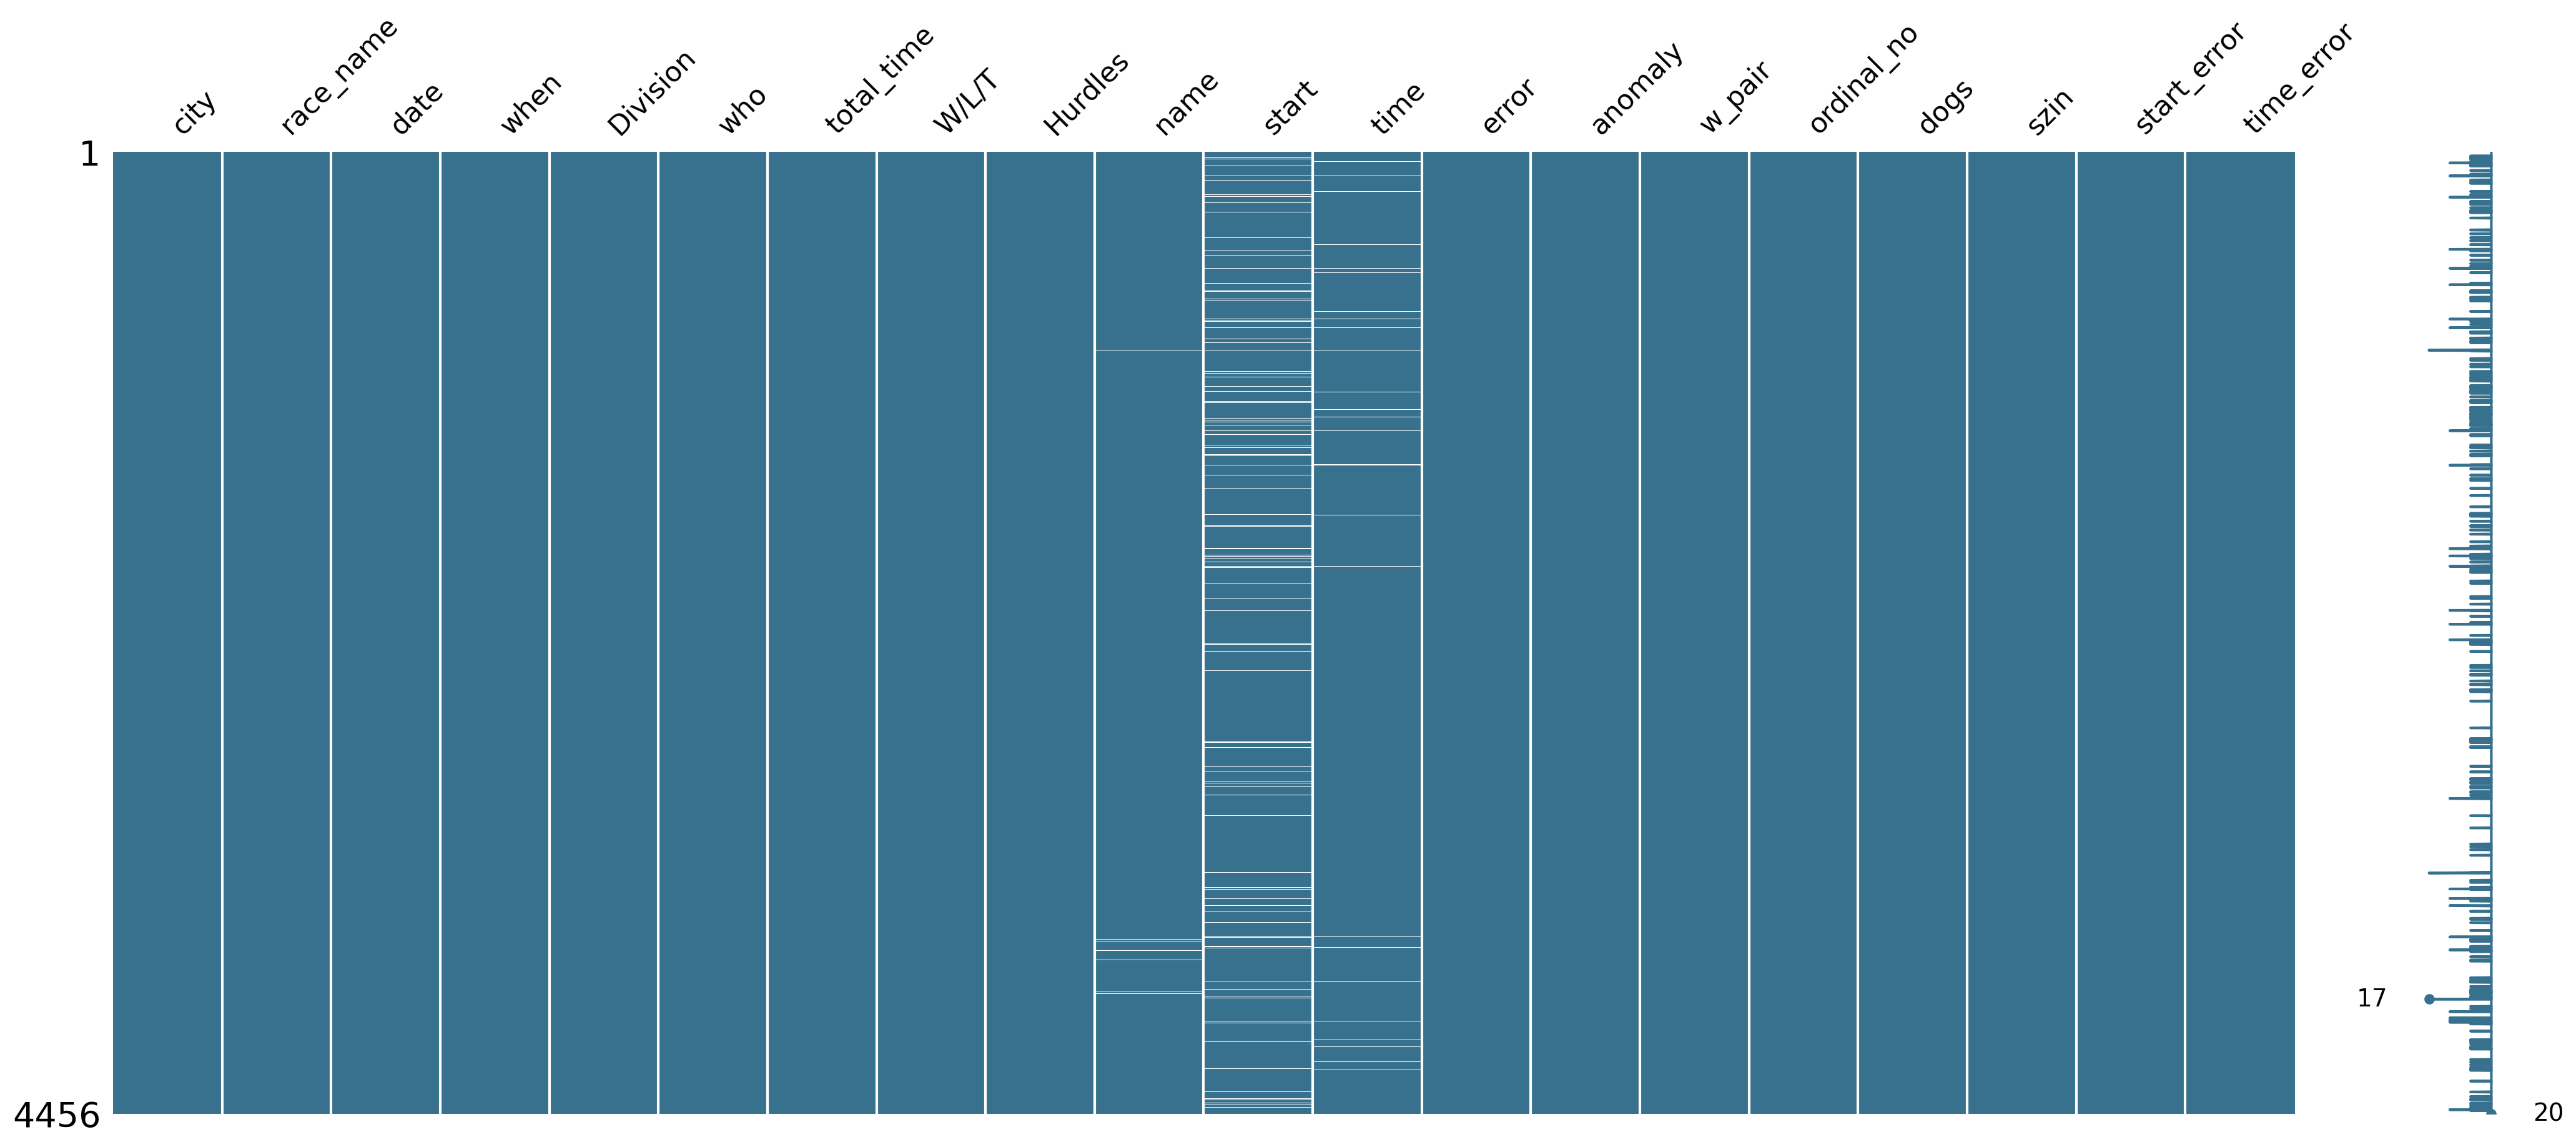

In [20]:
# Nézzük vizuálisan a null értékek helyzetét
msno.matrix(WR_cleaned, color=light_palette[4])
plt.show()

Az üres neveket el fogom dobni, de a start és time helyeken egyelőre megtartom a null értékeket, mivel a feltöltését ebben a pontban még nem érzem hasznosnak az elemzés szempontjából. Azt tudnám tenni, hogy feltöltöm ezeket az időket az adott kutya átlagával, mint talán legjobb megoldás, ám ezen még gondolkodom, és ha látom ennek előnyét, akkor visszatérek ide.

In [21]:
# Számosság tekintetében ugyan ez az információ
WR_cleaned.isnull().sum()

city             0
race_name        0
date             0
when             0
Division         0
who              0
total_time       0
W/L/T            0
Hurdles          0
name            16
start          296
time            80
error            0
anomaly          0
w_pair           0
ordinal_no       0
dogs             0
szin             0
start_error      0
time_error       0
dtype: int64

In [22]:
# Eldobok minden olyan sort, ahol null értékem van a name változóban, azaz nem tudom azonosítani a kutyát
WR_cleaned.dropna(subset=['name'], inplace = True)
WR_cleaned.reset_index(drop=True, inplace=True)

### 2.1 Az akadályok áttekintése

In [23]:
# A két doksi alapján ezek az elgadott méretek, nincs 32.5 és 35 ...
['15', '17.5', '20', '22.5', '25', '27,5', '30']

['15', '17.5', '20', '22.5', '25', '27,5', '30']

In [24]:
# 32.5-es érték nincsen, ezért ezeket meg kell vizsgálni a két df-ben, majd átalakítani megfelelően
WR_cleaned['Hurdles'].value_counts().sort_index()

Hurdles
15.0     464
20.0     151
22.5     200
25.0    1978
27.5    1519
30.0     116
32.5      12
Name: count, dtype: int64

In [25]:
dogs['ugrasi_magassag'].value_counts().sort_index()

ugrasi_magassag
15.0     2
20.0     2
22.5     2
25.0     7
27.5    14
30.0    10
32.5    14
Name: count, dtype: int64

Miután azt feltételezem, hogy ezek adatrögzítési hibák, és a valóságban nem ilyen magasságon futottak a kutyák, ezért alapfeltételezésem szerint átalakítom a legmagasabb jóváhagyott akadályokra ezeket, ám normál esetben ezt jó lenne átbeszélni

In [26]:
# Mivel a fentiek szerint nincsenek ilyen méretek, így 32.5-et 30-ra alakítom át
WR_cleaned['Hurdles'].replace(32.5, 30.0, inplace=True)

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_74656/1392585123.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  WR_cleaned['Hurdles'].replace(32.5, 30.0, inplace=True)


In [27]:
dogs['ugrasi_magassag'].replace(32.5, 30.0, inplace=True)

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_74656/1465109410.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dogs['ugrasi_magassag'].replace(32.5, 30.0, inplace=True)


### 2.2 Van-e duplikált sorom?

In [28]:
WR_cleaned[WR_cleaned.duplicated()]

,city,race_name,date,when,Division,who,total_time,W/L/T,Hurdles,name,start,time,error,anomaly,w_pair,ordinal_no,dogs,szin,start_error,time_error


Elsőre úgy látom, hogy két azonos sorom nincsen, de egy kicsit alacsonyabb szinten is szeretem megvizsgálni a duplukációkat, így bizonyos változók együttállását is annak tekintem.

In [33]:
# Itt azt vizsgálom, hogy van-e olyan időpont és kutya, aki egy időben futott volna, mert azt is duplikációnak tekinteném
dupla_futas = WR_cleaned.groupby(['date', 'when', 'name'])['time'].count().reset_index().sort_values('time', ascending=False)

In [34]:
dupla_futas[dupla_futas['time'] > 1]

,date,when,name,time
105,2023-04-22,10:13:25,Bella,2
106,2023-04-22,10:13:25,Bree,2
111,2023-04-22,10:13:25,Rocky,2


Érdekes módon van egy olyan eset, amikor a kutya kétszer is futott az adott pillanatban ám mégis más eredmény tartozik a futásához. Ezt mindenképp egyeztetni kellene normál esetben, hogy mi lehet ennek az oka..

In [40]:
WR_cleaned[(WR_cleaned['name'] == 'Bella') & (WR_cleaned['when'] == '10:13:25')].index

Index([14, 391], dtype='int64')

Egy példa a fenti anomáliára

Egy másik érdekes eset, hogy vannak olyan futások, amelyek ugyan más napokon történtek, ám mégis az adott kutya pontosan azonos időpontban versenyzett (megjegyzem, hogy mivel más sorszámmal indult, nem teljesen azonos a futási ideje illetve tartalmazza a fenti anomáliát is)

In [36]:
# Itt azt vizsgálom, hogy van-e olyan időpont és kutya, aki egy időben futott volna, mert azt is duplikációnak tekinteném
dupla_ido = WR_cleaned.groupby(['when', 'name'])['time'].count().reset_index().sort_values('time', ascending=False)

In [37]:
dupla_ido[dupla_ido['time'] > 1]

,when,name,time
1681,11:31:27,Hank,2
1797,11:47:47,Bree,2
822,10:13:25,Bree,2
827,10:13:25,Rocky,2
821,10:13:25,Bella,2
3298,14:50:49,Bella,2
783,10:10:45,Dixie,2
742,10:08:22,Bonnie,2
1677,11:31:27,Abby,2
3304,14:50:49,Sara,2


Egy példa a fenti anomáliára

In [38]:
WR_cleaned[(WR_cleaned['name'] == 'Hank') & (WR_cleaned['when'] == '11:31:27')]

,city,race_name,date,when,Division,who,total_time,W/L/T,Hurdles,name,start,time,error,anomaly,w_pair,ordinal_no,dogs,szin,start_error,time_error
1595,Prostějov,BCCCZ mistrovství,2023-06-24,11:31:27,2,Wildrunners Zephyr,19.59,L,25.0,Hank,0.50,4.47,False,False,False,2,"['Brix', 'Hank', 'Bella', 'Abby']",0,False,False
2238,Nové,Crazy Cup,2023-07-01,11:31:27,5,Wildrunners Zephyr,19.19,L,27.5,Hank,0.19,4.62,False,False,False,1,"['Hank', 'Alex', 'Mason', 'Abby']",0,False,False


Van egy anomaly oszlopom, ezért az első esetet mindeképp jelölöm arra az esetre, ha később ezt ki szeretném szűrni

## 2.3 WR Numerikus változók vizsgálata - Outlier-ek

Az outlierek elemzése nagyon fontos része az adatok ellenőrzésének, hiszen ezek a nagy halmaztól erősen eltérő esetek adott esetben új információval rendelkezhetnek, de éppen úgy lehetséges az is, hogy adatgyűjtési hiba miatt kerültek az adatok közé.

In [42]:
WR_cleaned.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Division,4440.000000,2.998874,2.383061,1.000000,1.000000,2.000000,4.000000,13.000000
total_time,4440.000000,21.108072,7.052473,4.160000,17.240000,18.600000,22.250000,86.030000
Hurdles,4440.000000,24.671734,3.786374,15.000000,25.000000,25.000000,27.500000,30.000000
start,4149.000000,0.345617,1.362376,-1.370000,0.000000,0.150000,0.300000,45.910000
time,4364.000000,4.497958,0.704540,3.020000,4.080000,4.280000,4.670000,15.320000
ordinal_no,4440.000000,2.495270,1.117142,1.000000,1.000000,2.000000,3.000000,4.000000
szin,4440.000000,0.502928,0.500048,0.000000,0.000000,1.000000,1.000000,1.000000


A fentiek alapján a következő észrevételem van elsőre:

- total_time - látszik túl alacsony és kiugró érték, de egyelőre ez az oszlop nem kiemelt, hiszen újra kell majd generálni a total_time-ot
- start - vannak negatív indítások, őket hibaként kezelem, de meghagyom, illetve extrém magas értékek, itt lehet adatgyűjtési hiba van
- time - elsőre a 3.02 érdekes, hiszen világrekord lenne, felfelé 15.32 inkább valami futási hiba, nem tizedes probléma

In [43]:
WR_cleaned.columns

Index(['city', 'race_name', 'date', 'when', 'Division', 'who', 'total_time',
       'W/L/T', 'Hurdles', 'name', 'start', 'time', 'error', 'anomaly',
       'w_pair', 'ordinal_no', 'dogs', 'szin', 'start_error', 'time_error'],
      dtype='object')

In [44]:
# Szétválasztom numerikus változókra
# numerikus változók
num_columns = [column for column in WR_cleaned.columns if WR_cleaned[column].dtype in ['float64', 'int64']]

In [45]:
num_columns

['Division', 'total_time', 'Hurdles', 'start', 'time', 'ordinal_no', 'szin']

A total_time esetén azt tudjuk, hogy nem mindig egyezik az idők összegével, vannak "láthatatlan" futások, így nem tudok erre az oszlopra hagyatkozni az elemzés során.
A Division, ordinal_no és szin kategórikus változók, ezeket később átalakítom

In [46]:
# Elsősorban most az alábbi két változó kapcsán viszgálom az outlier értékeket
num_columns = ['start', 'time']

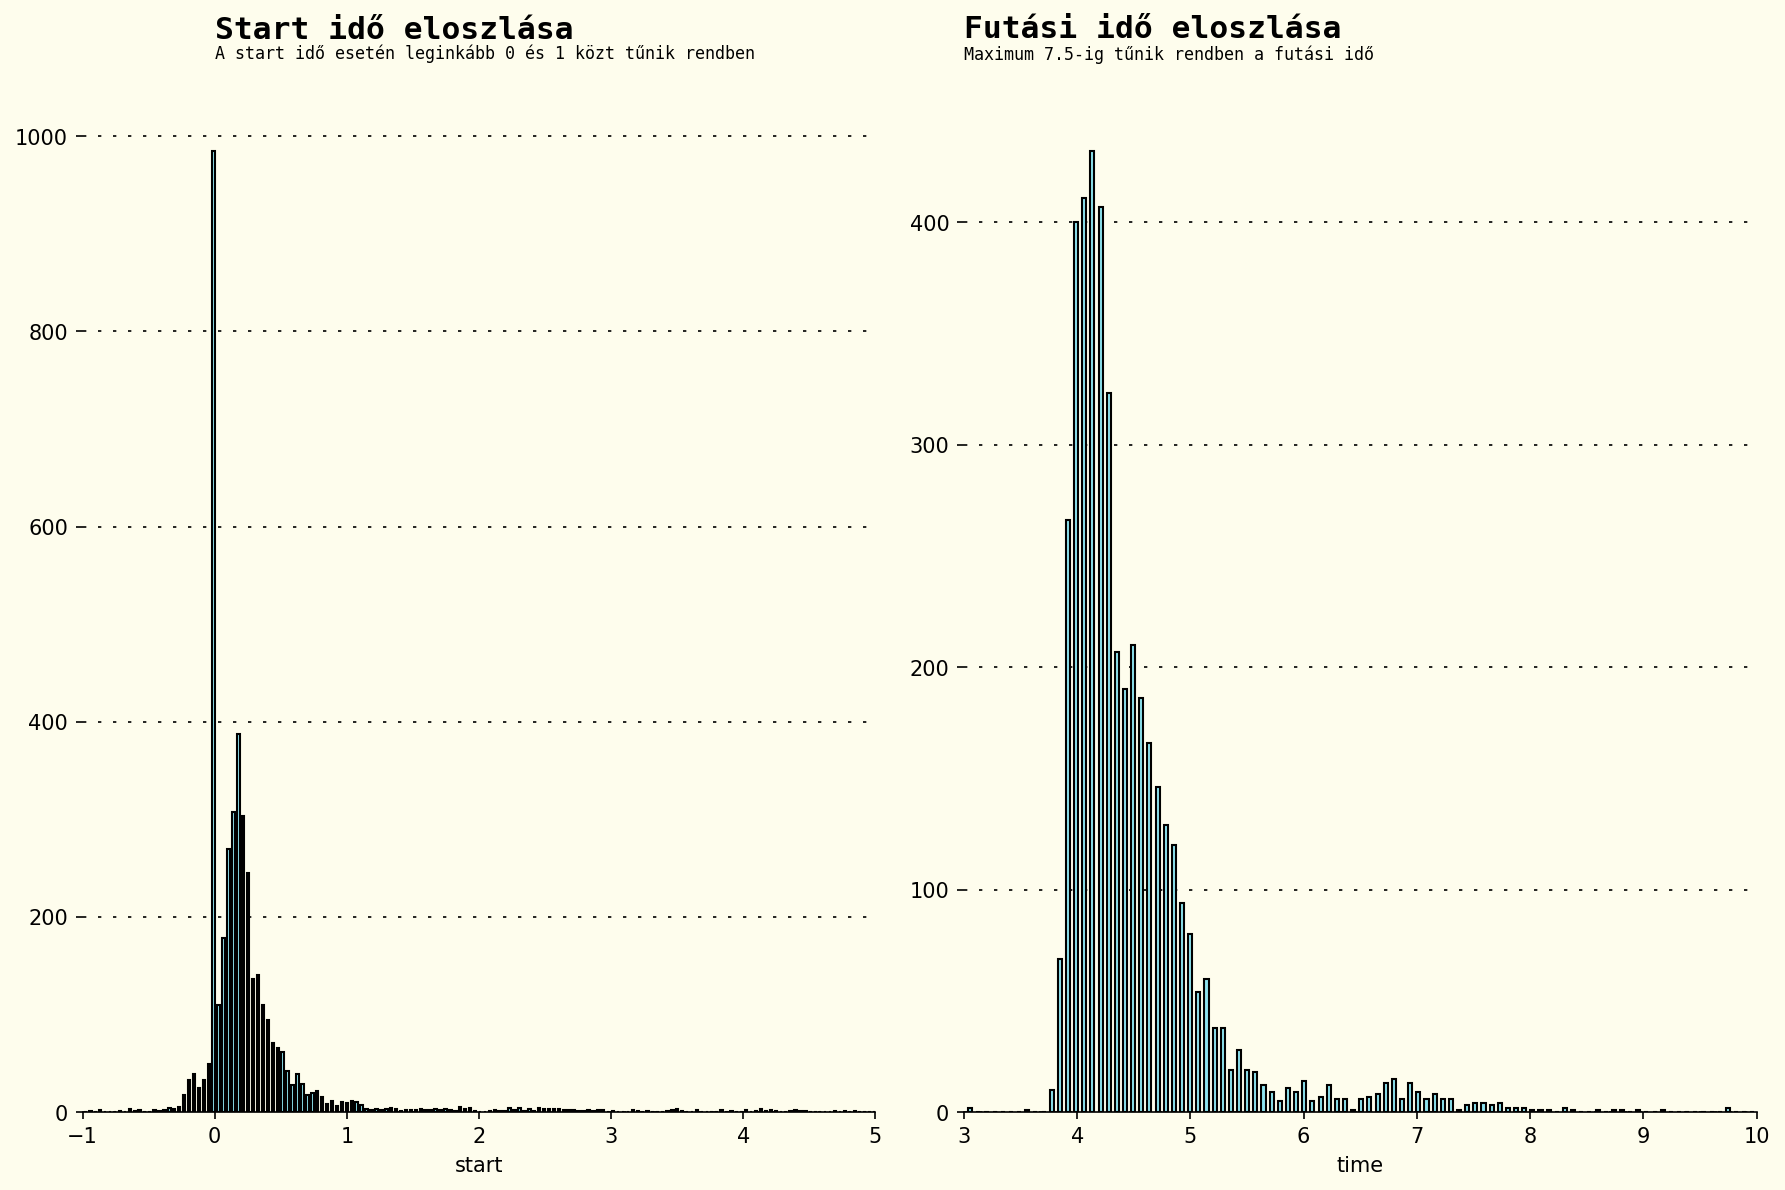

In [47]:
fig = plt.figure(figsize=(12,8), dpi=150)
gs = fig.add_gridspec(1,2)
ax = [None for _ in range(2)]
background_color = "#FEFDED"
fig.patch.set_facecolor(background_color) # figure background color

ax[0] = fig.add_subplot(gs[0,0])
ax[1] = fig.add_subplot(gs[0,1])
ax[0].set_facecolor(background_color) # axes background color
ax[1].set_facecolor(background_color)

ax[0].text(0,1100,'Start idő eloszlása',fontsize=15,fontweight='bold', fontfamily='monospace')
ax[0].text(0,1080,'A start idő esetén leginkább 0 és 1 közt tűnik rendben',fontsize=8,fontweight='light', fontfamily='monospace')

ax[1].text(3,483, 'Futási idő eloszlása',fontsize=15,fontweight='bold', fontfamily='monospace')
ax[1].text(3,473,'Maximum 7.5-ig tűnik rendben a futási idő',fontsize=8,fontweight='light', fontfamily='monospace')

sns.histplot(x=WR_cleaned['start'],ax=ax[0], color='#8EE3EF', alpha=1,zorder=3,linewidth=1,edgecolor='black', shrink=0.5)
sns.histplot(x=WR_cleaned['time'],ax=ax[1], color='#8EE3EF', alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5)

for i in range(2):
    ax[i].set_ylabel('')
    ax[i].grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

ax[0].set_xlim(-1,5)
ax[1].set_xlim(3,10)
        
plt.tight_layout()

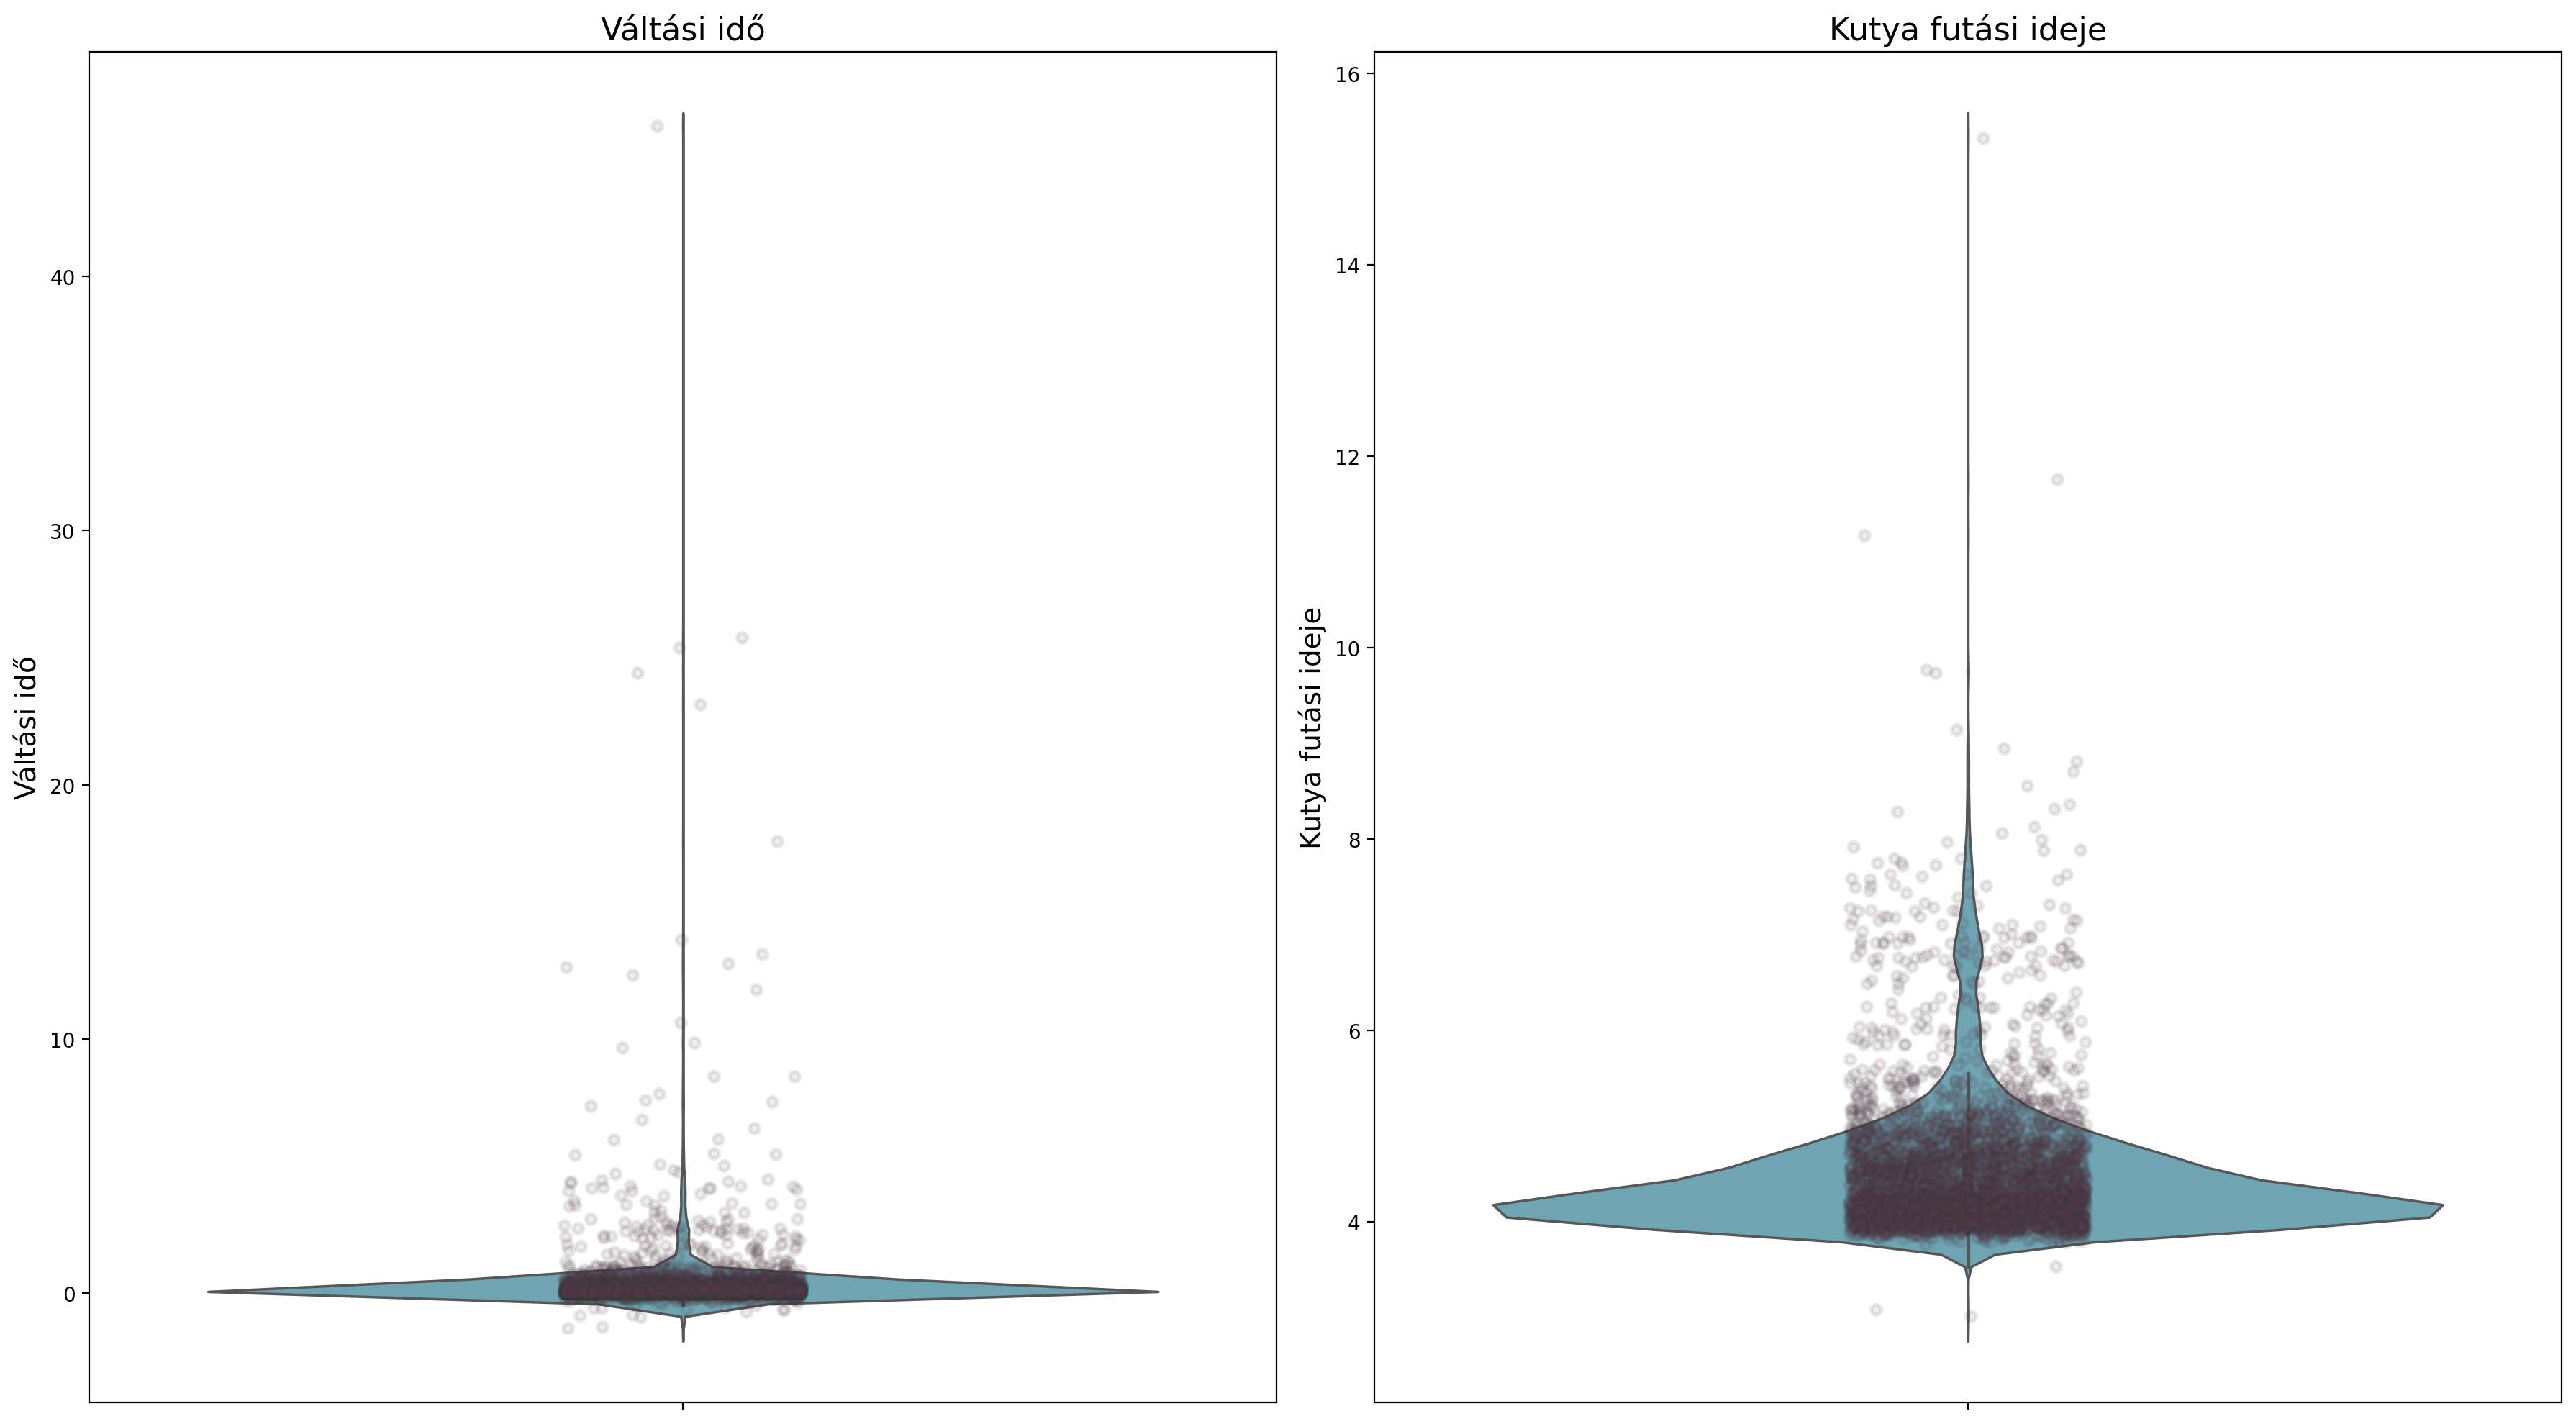

In [92]:
feature_names_full = {
    'start': 'Váltási idő',
    'time': 'Kutya futási ideje'
}
num_outliers(WR_cleaned, num_columns, feature_names_full)

Nézzük most azt, hogy mit mesél nekünk egyenként most a két változó, ötvözve azzal a fenti képet is

In [53]:
WR_cleaned['start'].describe()

count    4149.000000
mean        0.345617
std         1.362376
min        -1.370000
25%         0.000000
50%         0.150000
75%         0.300000
max        45.910000
Name: start, dtype: float64

In [48]:
WR_cleaned['start'].quantile([0.25, .5, .75, .9, .95, 0.96, .99])

0.25    0.0000
0.50    0.1500
0.75    0.3000
0.90    0.5800
0.95    0.9900
0.96    1.2408
0.99    4.1604
Name: start, dtype: float64

Ezekből számomra az látszik, a szabályok alapján is, hogy minden nulla alatti idő hibás, továbbá érzés alapján nekem 0 95-ös szintet meghúzva az 1mp-nél tovább tartó indulás is jelzés arra vonatkozólag, hogy valamilyen hiba lehet az indulással

In [58]:
WR_cleaned['start_outlier'] = WR_cleaned['start'].apply(
    [lambda x: 1 if (x < 0) | (x > WR_cleaned['start'].quantile(0.95)) else 0]
)

In [52]:
WR_cleaned['time'].describe()

count    4364.000000
mean        4.497958
std         0.704540
min         3.020000
25%         4.080000
50%         4.280000
75%         4.670000
max        15.320000
Name: time, dtype: float64

In [50]:
# time esetén vannak 
WR_cleaned['time'].quantile([0.05, 0.25, .5, .75, .9, .95, 0.96, .99])

0.05    3.9300
0.25    4.0800
0.50    4.2800
0.75    4.6700
0.90    5.1300
0.95    5.7700
0.96    6.1248
0.99    7.2974
Name: time, dtype: float64

A time azaz futási idő esetén a minimum idő nagyon alacsonynak tűnik annak tekintetében, hogy a világcsúcs közeli idők is 3.5 körül vannak

In [57]:
WR_cleaned['time'].sort_values().head(10)

1573    3.02
3835    3.09
4367    3.54
4044    3.76
4090    3.79
4092    3.79
4082    3.79
1355    3.79
3946    3.80
1306    3.80
Name: time, dtype: float64

A fentiek alapján az első kettő számomra inkább outlier, a harmadik pedig egyeztetés tárgya lenne

In [59]:
WR_cleaned['outlier'] = WR_cleaned['time'].apply(
    [lambda x: 1 if (x < 3.54) | (x > WR_cleaned['time'].quantile(0.99)) else 0]
)

## 2.4 WR kategorikus változók elemzése

In [60]:
WR_cleaned.columns

Index(['city', 'race_name', 'date', 'when', 'Division', 'who', 'total_time',
       'W/L/T', 'Hurdles', 'name', 'start', 'time', 'error', 'anomaly',
       'w_pair', 'ordinal_no', 'dogs', 'szin', 'start_error', 'time_error',
       'start_outlier', 'outlier'],
      dtype='object')

In [121]:
cat_columns = ['city', 'race_name', 'date', 'when', 'Division', 'who', 'W/L/T', 'Hurdles', 'name', 'szin']

In [123]:
for feature in cat_columns:
    print(f'A {feature} változó értékeinek eloszlása: {WR_cleaned[feature].value_counts()}')
    print(f'------------------------')

A city változó értékeinek eloszlása: city
Blšany              759
Prostějov           728
Heroltice           640
Nové                596
Žamberk             546
Litomyšl            347
Louňovice           300
Vodňany             288
Tápiószentmárton    236
Name: count, dtype: int64
------------------------
A race_name változó értékeinek eloszlása: race_name
BCCCZ mistrovství              728
Hanácké škvarek                640
Crazy Cup                      596
Eager´s Cup 1. ring            466
Mistrovství České republiky    451
Křupky na břehu                347
Flyvaryors turnaj              308
Máchale, spadlo ti to!         300
Budějckej xtreme 2. ring       288
EFC - Ring 2                   120
EFC - Ring 1                   116
Eager´s Cup 2. ring             80
Name: count, dtype: int64
------------------------
A date változó értékeinek eloszlása: date
2023-06-24    728
2023-04-22    640
2023-07-01    596
2023-05-06    546
2023-09-03    451
2023-09-16    347
2023-05-20    308


A fentiekből kicsit mélyebben a kutyák érdekelnek, illetve pár változó, amely talán kicsit jobban leírja a képet

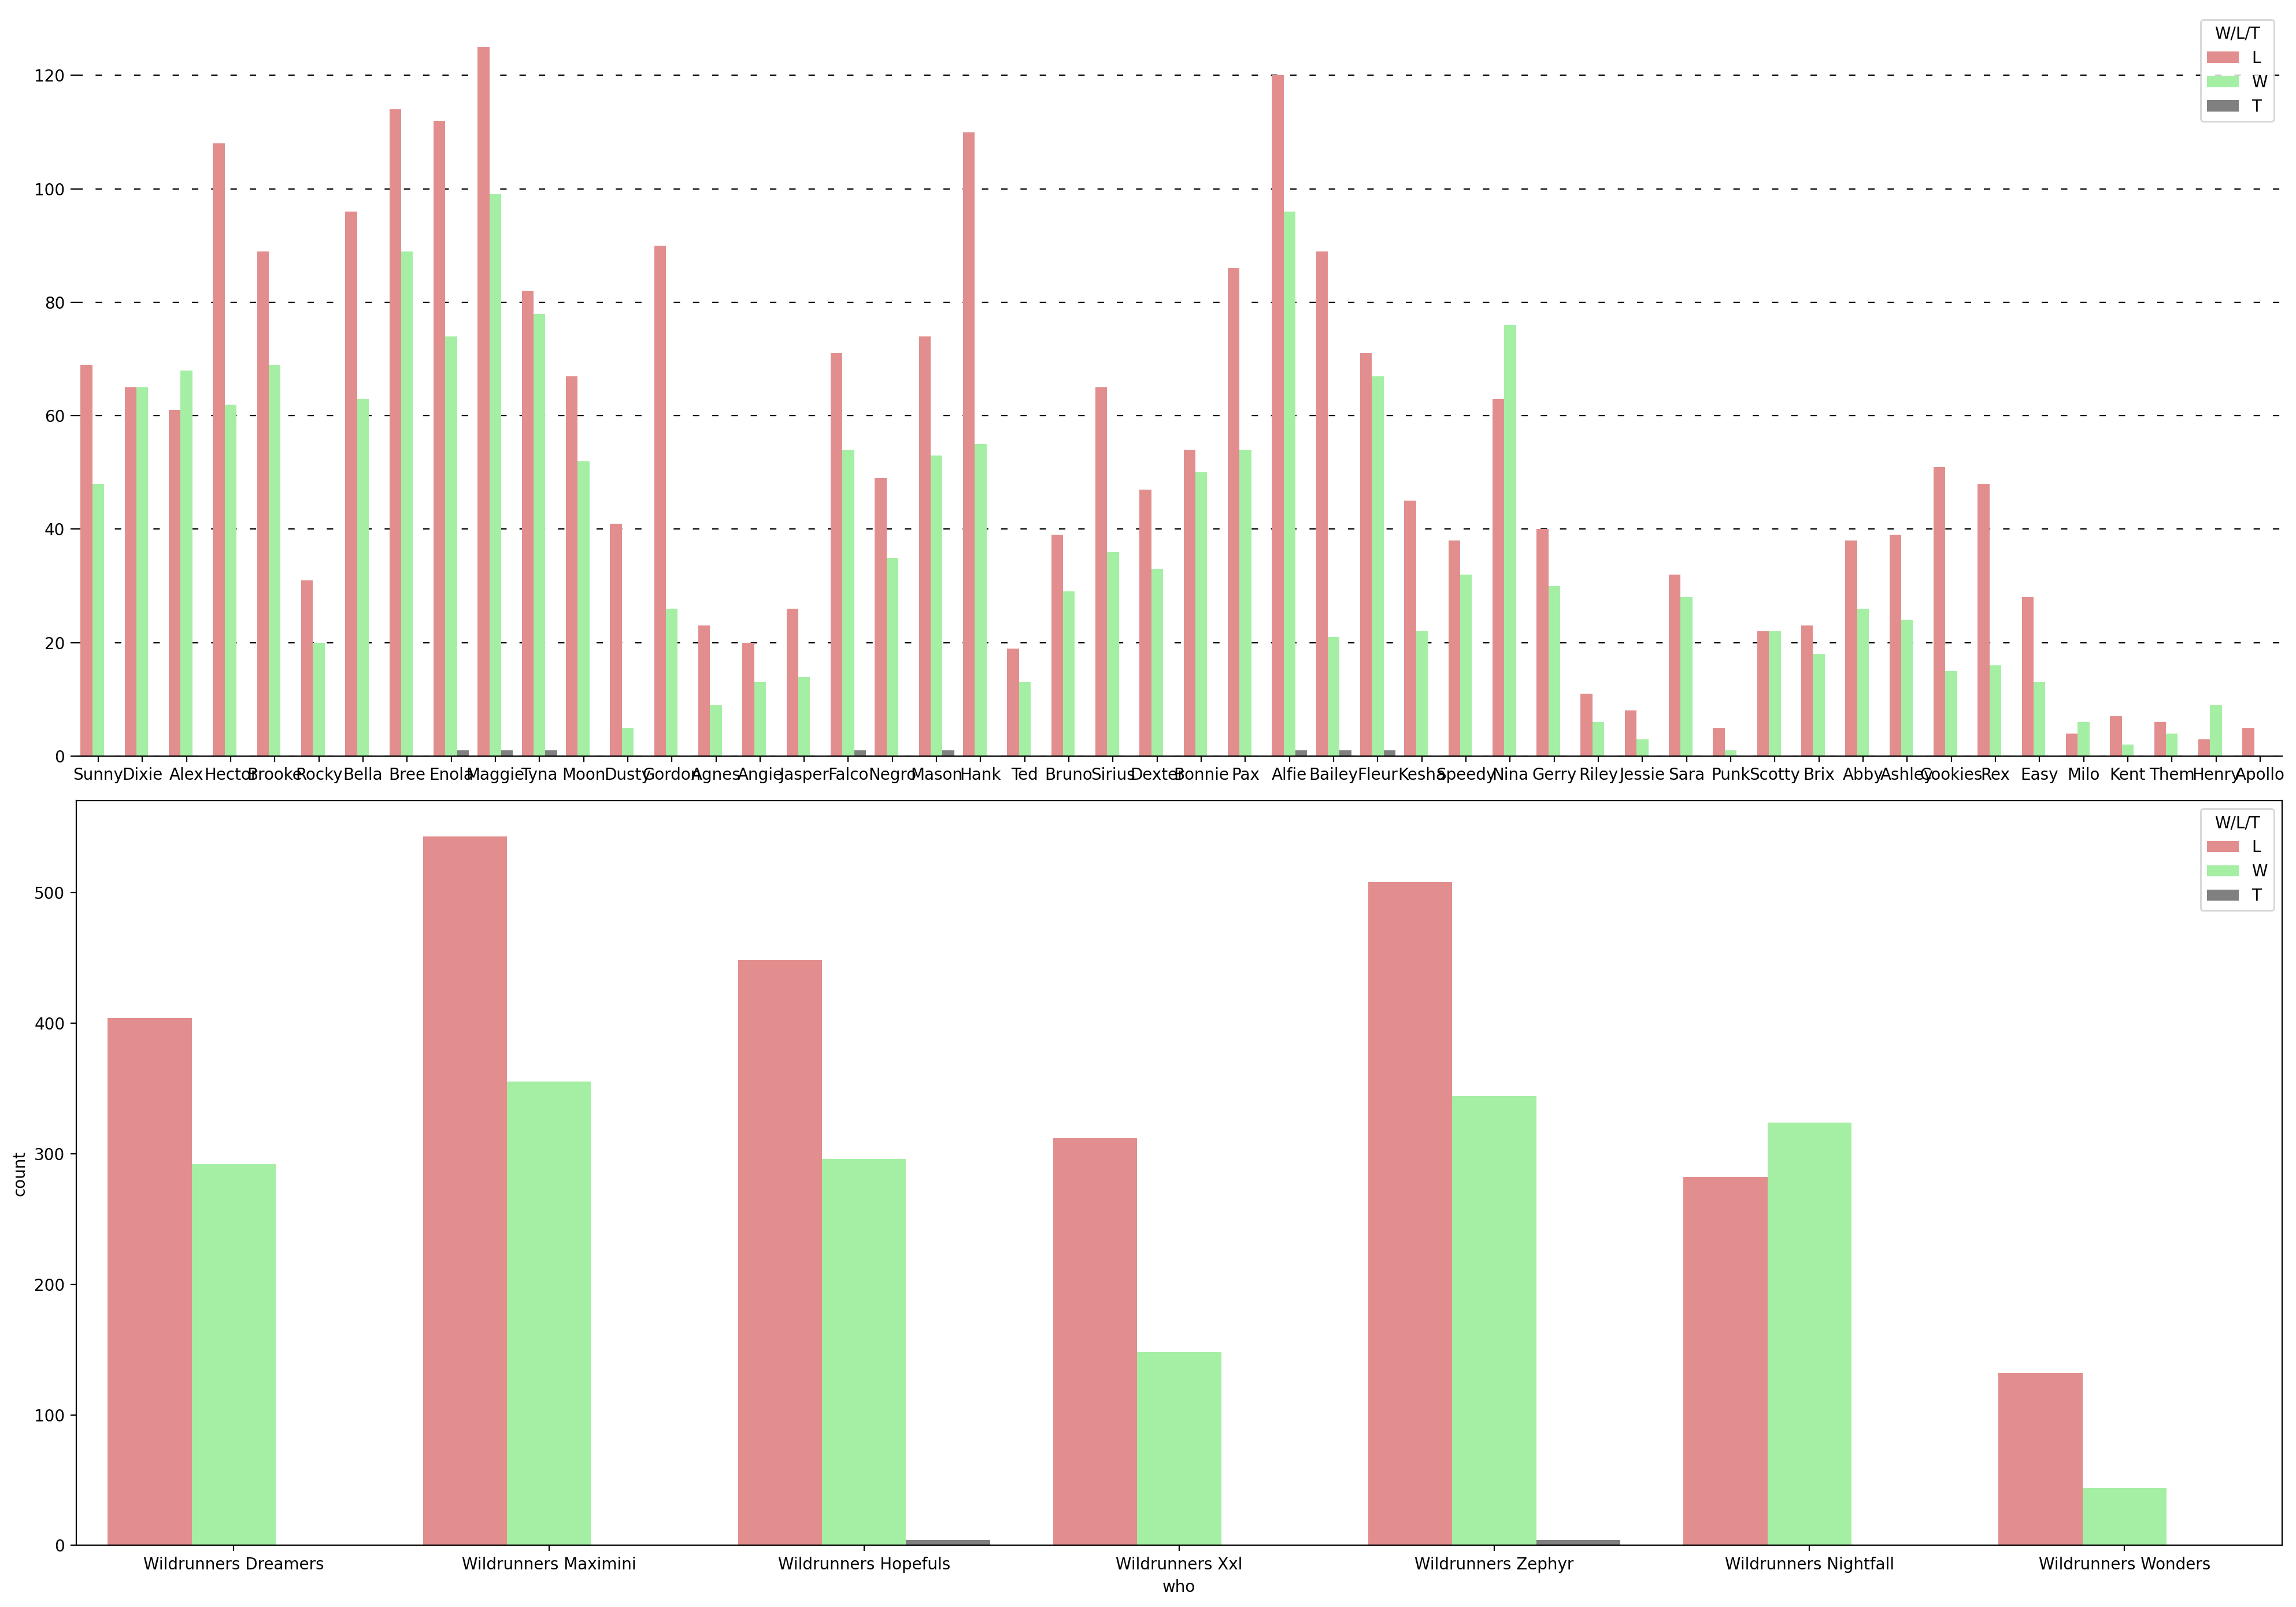

In [90]:
fig=plt.figure(figsize=(20,14),facecolor='white')

gs=fig.add_gridspec(2,1)

ax=[None for _ in range(2)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])

palette2=["lightcoral", "palegreen", "grey"]

sns.countplot(data=WR_cleaned,x='name',ax=ax[0],hue='W/L/T',zorder=2,palette=palette2)
sns.countplot(data=WR_cleaned,x='who',ax=ax[1],hue='W/L/T',zorder=2,palette=palette2)

for i in range(1):
    ax[i].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)
    #ax[0].set_xticklabels(WR_cleaned['name'], fontfamily='serif', rotation=90)
    #ax[1].set_xticklabels(WR_cleaned['who'], fontfamily='serif', rotation=90)
plt.tight_layout()

Kutyák esetén elsőre az látható, hpgy többségében kiegyensúlyozott az eredmény, van egy két kutya, amely esetén a nyert futamok adnak nagyobb számot és van olyan kutya is, amely meglepően sokszor volt vesztes futam részese.
Csapatoknál elsőre a Nightfall esetén van több győzelem, ám ez csak az első gyors áttekintés.

## 2.4 Dogs adathalmas - numerikus változók outlier detection

In [94]:
# Gyors áttekintés
dogs.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
chip_szam,51.000000,93900005643998.296875,2736044.980155,93900001206699.000000,93900003542806.500000,93900005539134.000000,93900008311913.000000,93900009884426.000000
ulna_hossz,51.000000,21.173922,29.464890,1.209000,14.960000,16.280000,17.775000,175.500000
ugrasi_magassag,51.000000,27.352941,3.654168,15.000000,26.250000,27.500000,30.000000,30.000000


In [95]:
# numerikus változók
num_columns_dogs = [column for column in dogs.columns if dogs[column].dtype in ['float64', 'int64']]

# objektum változók
cat_columns_dogs = [column for column in dogs.columns if dogs[column].dtype not in ['float64', 'int64']]

In [96]:
# a numerikus változók elemzése során kiveszem a chipek számát, amivel nem foglalkozom itt a numerikus válozóknál
num_columns_dogs = ['ulna_hossz', 'ugrasi_magassag']

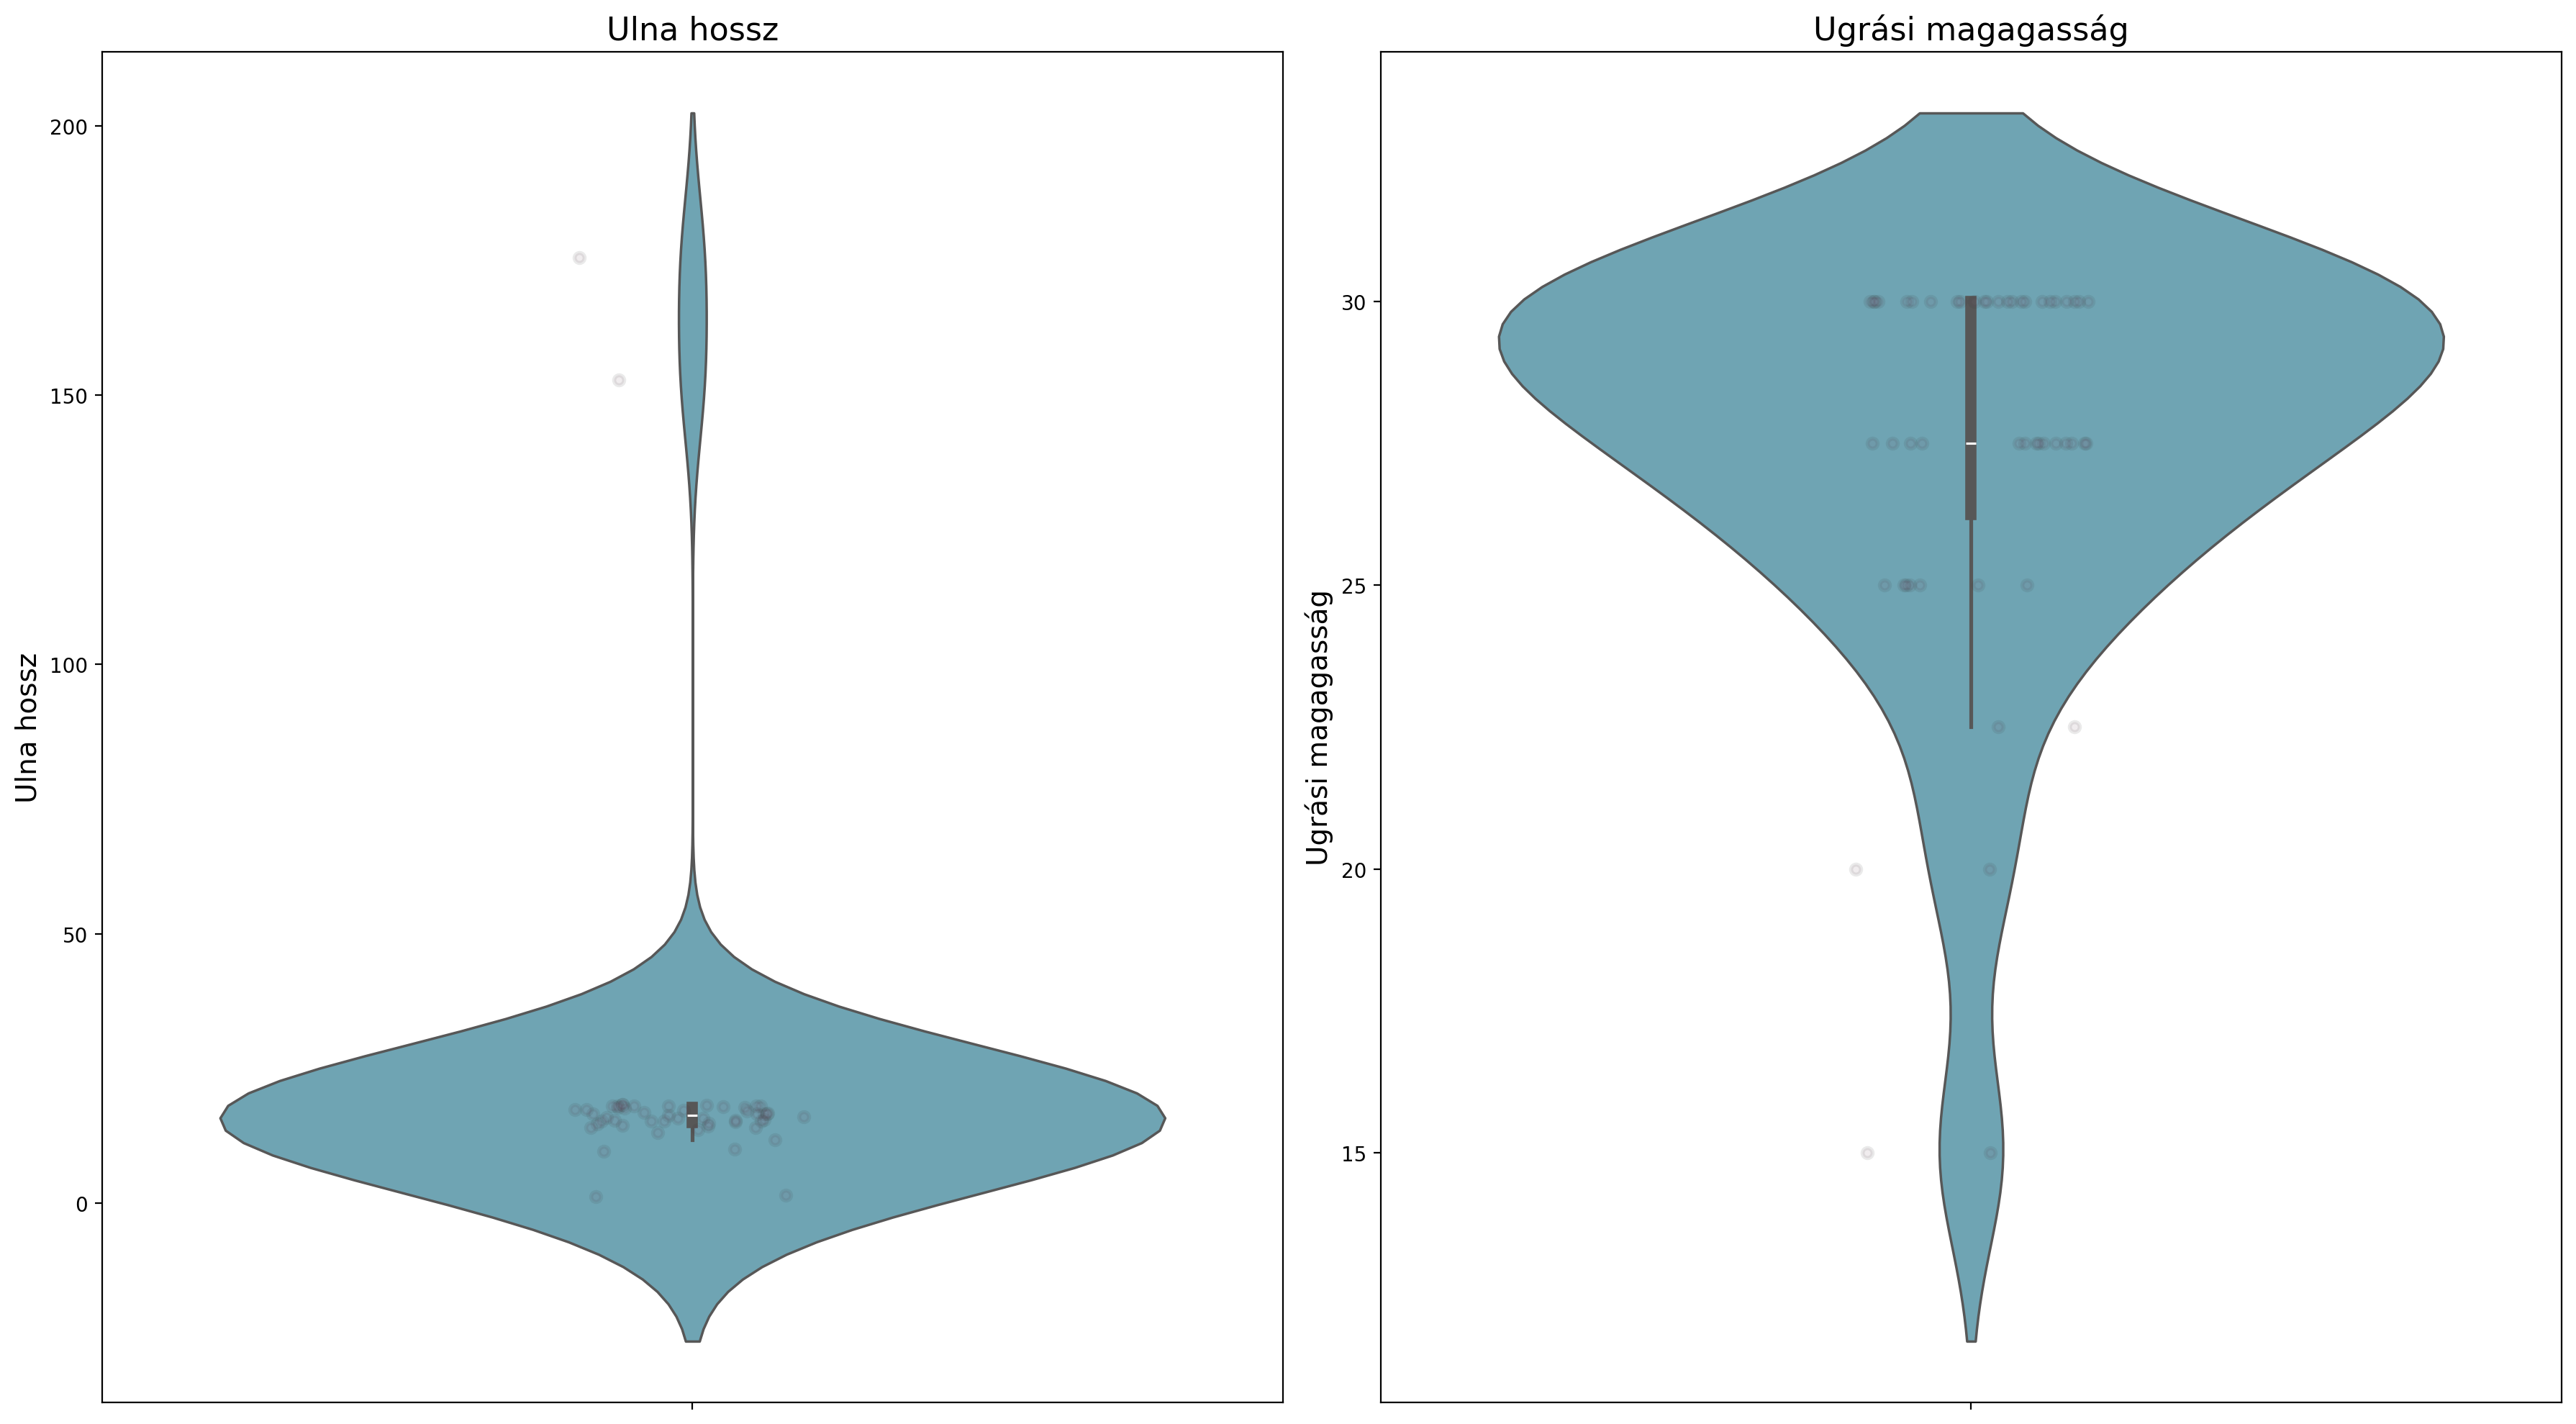

In [97]:
feature_names_full_dogs = {
    'ulna_hossz': 'Ulna hossz',
    'ugrasi_magassag': 'Ugrási magagasság'
}

num_outliers(dogs, num_columns_dogs, feature_names_full_dogs)

Az ulna hossz esetén egyértelmáen látszik az outlier, ami vélhetően egy tizedes probléma volt. Ezt javítom
Az ugrási magasság esetén is van pár eset, őket közelebbről is megnézem

In [98]:
dogs['ulna_hossz'].quantile([0, 0.25, 0.5, 0.75, 0.99])

0.00      1.209
0.25     14.960
0.50     16.280
0.75     17.775
0.99    164.150
Name: ulna_hossz, dtype: float64

In [99]:
dogs[(dogs['ulna_hossz']> 25) | (dogs['ulna_hossz'] < 15)]

,felvezeto,nev,fajta,nem,ivar,szuletesi_datum,chip_szam,ulna_hossz,ugrasi_magassag
0,TM800418,Dexter,Kooikerhondje,Kan,ivartalan,2010-02-14,93900005238999,14.050,25.0
5,OJ941014,Bella,American Staffordshire Terrier,Szuka,ivartalan,2015-02-27,93900009320601,14.700,25.0
6,HO800728,Gordon,Jack Russell Terrier,Kan,ivartalan,2015-04-12,93900001569304,9.670,15.0
10,DM850705,Speedy,Mix,Kan,ivartalan,2015-11-07,93900001547455,1.491,25.0
15,OK870605,Gerry,Australian Kelpie,Kan,ivartalan,2016-09-03,93900007728423,14.040,25.0
16,UB870201,Henry,Parson Russell Terrier,Kan,ivartalan,2017-04-15,93900008474491,1.209,20.0
19,JV990222,Punk,Small Schnauzer,Szuka,ivartalan,2017-07-04,93900007218892,10.020,15.0
21,UZ940717,Pax,Sheltie,Kan,ivartalan,2017-09-08,93900004293075,14.300,25.0
23,SO990728,Dusty,Parson Russell Terrier,Szuka,ivartalan,2017-12-21,93900005627226,13.030,22.5
25,IN920805,Bruno,Border Collie,Kan,ivartalan,2018-03-08,93900002928155,175.500,30.0


In [100]:
dogs['ulna_hossz'] = dogs['ulna_hossz'].apply(lambda x: x / 10 if x > 19 else x)
dogs['ulna_hossz'] = dogs['ulna_hossz'].apply(lambda x: x * 10 if x < 9 else x)

## 2.6 Dogs kategória változók elemzése

In [102]:
dogs_categorical_features = dogs.select_dtypes(include=['object', 'category']) \
                                  .columns.tolist()

In [104]:
dogs_categorical_features

['felvezeto', 'nev', 'fajta', 'nem', 'ivar', 'szuletesi_datum']

In [113]:
dogs['felvezeto'].value_counts()

felvezeto
TM800418    1
GB900808    1
TU820403    1
KL970722    1
EH831207    1
LZ800202    1
OA821108    1
HM980701    1
EC940409    1
NZ800507    1
EH800220    1
DU050516    1
RF840515    1
IS961124    1
TC041225    1
LF971218    1
GE030417    1
DD800226    1
LM070408    1
RN891016    1
LP030829    1
VK910426    1
MJ930217    1
NJ890324    1
UO880828    1
IN920805    1
NP950613    1
TV860229    1
UF830429    1
ZE801127    1
DP910919    1
OJ941014    1
HO800728    1
UR870607    1
RK871018    1
PO831026    1
DM850705    1
LO900912    1
WS810829    1
UO920408    1
MB801205    1
OK870605    1
UB870201    1
KL920415    1
BV810323    1
JV990222    1
AT991109    1
UZ940717    1
MT970826    1
SO990728    1
UH881130    1
Name: count, dtype: int64

In [115]:
for feature in dogs_categorical_features:
    print(f'A {feature} változó értékeinek eloszlása: {dogs[feature].value_counts()}')
    print(f'------------------------')

A felvezeto változó értékeinek eloszlása: felvezeto
TM800418    1
GB900808    1
TU820403    1
KL970722    1
EH831207    1
LZ800202    1
OA821108    1
HM980701    1
EC940409    1
NZ800507    1
EH800220    1
DU050516    1
RF840515    1
IS961124    1
TC041225    1
LF971218    1
GE030417    1
DD800226    1
LM070408    1
RN891016    1
LP030829    1
VK910426    1
MJ930217    1
NJ890324    1
UO880828    1
IN920805    1
NP950613    1
TV860229    1
UF830429    1
ZE801127    1
DP910919    1
OJ941014    1
HO800728    1
UR870607    1
RK871018    1
PO831026    1
DM850705    1
LO900912    1
WS810829    1
UO920408    1
MB801205    1
OK870605    1
UB870201    1
KL920415    1
BV810323    1
JV990222    1
AT991109    1
UZ940717    1
MT970826    1
SO990728    1
UH881130    1
Name: count, dtype: int64
------------------------
A nev változó értékeinek eloszlása: nev
Dexter     1
Sunny      1
Maggie     1
Them       1
Rocky      1
Dixie      1
Brix       1
Milo       1
Tyna       1
Abby       1
Easy       1


Két kutya van, aki azonos napon született, őket azért kicsit közelebbről most megnézem

In [117]:
dogs[dogs['szuletesi_datum'] == '2018-12-22']

,felvezeto,nev,fajta,nem,ivar,szuletesi_datum,chip_szam,ulna_hossz,ugrasi_magassag
30,EH831207,Rocky,Belgian Shepherd - Malinois,Kan,ivartalan,2018-12-22,93900003818036,18.29,30.0
31,LZ800202,Dixie,Border Collie,Kan,ivartalan,2018-12-22,93900002523549,14.36,25.0


In [118]:
dogs[dogs['szuletesi_datum'] == '2021-01-04']

,felvezeto,nev,fajta,nem,ivar,szuletesi_datum,chip_szam,ulna_hossz,ugrasi_magassag
42,GE030417,Moon,Border Collie,Szuka,ivaros,2021-01-04,93900006876951,17.35,30.0
43,DD800226,Sirius,Border Collie,Kan,ivartalan,2021-01-04,93900005539134,17.74,30.0


Mivel nem látok semmi furcsát, így feltételezem, hogy ez rendben van

# 3.0 Néhány változó átalakítása

In [124]:
WR_cleaned['napszak'] = WR_cleaned['when'].apply(lambda x: 0 if datetime.strptime(x, '%H:%M:%S').hour < 12 else 1)

In [125]:
WR_cleaned['date'] = pd.to_datetime(WR_cleaned['date'])
WR_cleaned['year'] = WR_cleaned['date'].dt.year
WR_cleaned['month'] = WR_cleaned['date'].dt.month
WR_cleaned['day'] = WR_cleaned['date'].dt.day

Létrehozok egy wlt változót, amely számokkal tartalmazza inkább a string értékeket

In [127]:
wlt = {'L': 0, 'T': 1, 'W': 2}
WR_cleaned['wlt'] = WR_cleaned['W/L/T'].map(wlt)

Véglegesítem a verseny adatokat tartalmazó fájlt

In [128]:
wr_final = WR_cleaned.copy()

Néhány változót kiveszek a további elemzésekből, amelyek vagy átalakításra kerültek, vagy nem érzem már jelentőségüket

In [129]:
wr_final.drop(['W/L/T', 'error','anomaly','w_pair'], axis=1, inplace=True)

In [130]:
wr_final.head()

,city,race_name,date,when,Division,who,total_time,Hurdles,name,start,time,ordinal_no,dogs,szin,start_error,time_error,start_outlier,outlier,napszak,year,month,day,wlt
0,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,25.0,Sunny,-0.24,4.21,1,"['Sunny', 'Dixie', 'Alex', 'Hector']",0,True,False,1,0,0,2023,4,22,0
1,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,25.0,Dixie,0.30,4.24,2,"['Sunny', 'Dixie', 'Alex', 'Hector']",0,False,False,0,0,0,2023,4,22,0
2,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,25.0,Alex,0.16,4.22,3,"['Sunny', 'Dixie', 'Alex', 'Hector']",0,False,False,0,0,0,2023,4,22,0
3,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Dreamers,17.01,25.0,Hector,0.00,4.13,4,"['Sunny', 'Dixie', 'Alex', 'Hector']",0,False,False,0,0,0,2023,4,22,0
4,Heroltice,Hanácké škvarek,2023-04-22,10:11:57,1,Wildrunners Maximini,19.43,25.0,Brooke,-0.11,4.08,1,"['Brooke', 'Rocky', 'Bella', 'Bree']",1,True,False,1,0,0,2023,4,22,0


## 3.1 Dogs dataset véglegesítése

Születési dátum átalakítása dátummá

In [ ]:
dogs['szuletesi_datum'] = pd.to_datetime(dogs['szuletesi_datum'])

In [131]:
dogs.head()

,felvezeto,nev,fajta,nem,ivar,szuletesi_datum,chip_szam,ulna_hossz,ugrasi_magassag
0,TM800418,Dexter,Kooikerhondje,Kan,ivartalan,2010-02-14,93900005238999,14.05,25.0
1,NP950613,Jasper,Border Collie,Kan,ivartalan,2011-03-28,93900007189034,16.56,30.0
2,UF830429,Angie,Border Collie,Szuka,ivartalan,2014-02-06,93900003827629,15.22,27.5
3,ZE801127,Alex,Border Collie,Kan,ivartalan,2014-04-22,93900003598960,17.95,30.0
4,DP910919,Ashley,Border Collie,Szuka,ivartalan,2015-01-26,93900009738344,18.30,30.0


# 4.0 Adathalmazok összeolvasztása elemzéshez